### CNN for ECG Signal Classification (5 classes)  - Keras

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adamax
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import pandas as pd

### Load the data

In [2]:
X=pd.read_csv('ECG_dataX.csv')
Y=pd.read_csv('ECG_dataY.csv')

In [3]:
#convert dataframe to numpy array
X=X.values
X.shape

(3841, 187)

In [4]:
#convert dataframe to numpy array
Y=Y.values
Y.shape

(3841, 1)

In [5]:
#reshape Y into a 1D array
Y=Y.reshape(-1)
Y.shape

(3841,)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

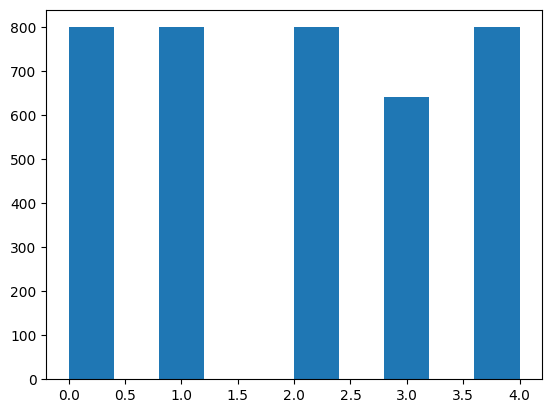

In [6]:
plt.hist(Y)

In [7]:
fs=125  # sampling frequency
Ts=1/fs # sampling interval
N=187 # the number of timepoints
Duration=N*Ts # duration of a signal
t=np.linspace(0, Duration-Ts, N) # array of timepoints

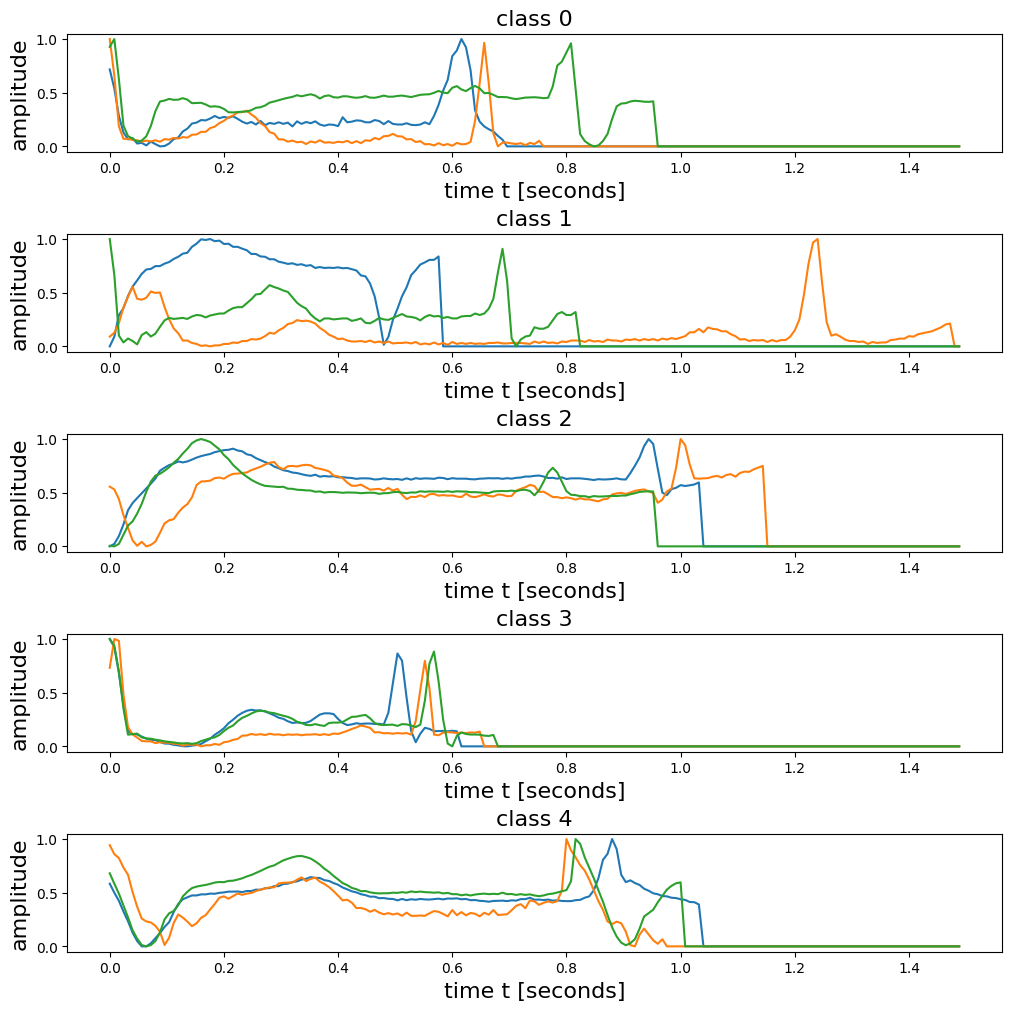

In [8]:
fig, ax = plt.subplots(5,1,constrained_layout=True, figsize=(10,10))
for c in range(0, 5):   
    for n in range(0, 3):
        idx=np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])        
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('class '+str(c), fontsize=16)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
#note: add a channel axis to the data if the network is CNN: see the examples presented in class

In [10]:
X_train.shape

(2764, 187)

In [11]:
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_val=X_val.reshape(X_val.shape[0], X_val.shape[1],1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [12]:
X_train.shape

(2764, 187, 1)

### CNN model

In [13]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *
from tensorflow.keras.layers import AveragePooling1D, Conv1D, Flatten
import keras.layers.normalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adamax


inputs = Input(shape=(187,1))
C1=Conv1D(filters=32, kernel_size=5, strides=2, padding='valid')(inputs)
A1 = Activation("relu")(C1)

C2 = Conv1D(filters=32, kernel_size=2, strides=2, padding='valid')(A1)
A2 = Activation("relu")(C2)
Avg1 = AveragePooling1D(pool_size=2, strides=2, padding='valid')(A1)
S2 = Add()([A2, Avg1])

N3 = BatchNormalization()(S2)
C3 = Conv1D(filters=32, kernel_size=2, strides=2, padding='valid')(N3)
A3 = Activation("relu")(C3)
Avg2 = AveragePooling1D(pool_size=2, strides=2, padding='valid')(S2)
S3 = Add()([A3, Avg2])

N4 = BatchNormalization()(S3)
C4 = Conv1D(filters=32, kernel_size=2, strides=2, padding='valid')(N4)
A4 = Activation("relu")(C4)
Avg3 = AveragePooling1D(pool_size=2, strides=2, padding='valid')(S3)
S4 = Add()([A4, Avg3])

N5 = BatchNormalization()(S4)
C5 = Conv1D(filters=32, kernel_size=2, strides=2, padding='valid')(N5)
A5 = Activation("relu")(C5)

F1 = Flatten()(A5)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
A7 = Softmax()(D2)

model = Model(inputs=inputs, outputs=A7)

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adamax(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 92, 32)       192         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 92, 32)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 46, 32)       2080        ['activation[0][0]']             
                                                                                              

In [14]:
loss_train_list=[]
loss_val_list=[]
acc_train_list=[]
acc_val_list=[]
epoch_save=-1

### Train the model

In [15]:
epoch = 0
for epoch in range(epoch_save+1, 100): #change 100 to a larger number if necessary
    print('epoch', epoch)
    #set epochs=1
    history=model.fit(X_train, Y_train, batch_size=64, epochs=1, validation_data=(X_val, Y_val))
    loss_train_list.extend(history.history['loss'])
    loss_val_list.extend(history.history['val_loss'])
    acc_train_list.extend(history.history['accuracy'])
    acc_val_list.extend(history.history['val_accuracy'])
    #save the model to a a HDF5 file 
    model.save('ECG_Keras_sCE_e'+str(epoch)+'.h5')

epoch 0
44/44 [==============================] - 1s 9ms/step - loss: 2.3041 - accuracy: 0.4287 - val_loss: 3.0598 - val_accuracy: 0.2435
epoch 1
44/44 [==============================] - 0s 4ms/step - loss: 0.9406 - accuracy: 0.7033 - val_loss: 2.4818 - val_accuracy: 0.2175
epoch 2
44/44 [==============================] - 0s 4ms/step - loss: 0.7112 - accuracy: 0.7413 - val_loss: 2.1628 - val_accuracy: 0.2240
epoch 3
44/44 [==============================] - 0s 4ms/step - loss: 0.6161 - accuracy: 0.7742 - val_loss: 1.9896 - val_accuracy: 0.2013
epoch 4
44/44 [==============================] - 0s 4ms/step - loss: 0.5564 - accuracy: 0.8025 - val_loss: 1.9460 - val_accuracy: 0.1916
epoch 5
44/44 [==============================] - 0s 5ms/step - loss: 0.5155 - accuracy: 0.8104 - val_loss: 1.9207 - val_accuracy: 0.1916
epoch 6
44/44 [==============================] - 0s 4ms/step - loss: 0.4823 - accuracy: 0.8209 - val_loss: 1.8470 - val_accuracy: 0.1948
epoch 7
44/44 [==========================

### Plot training loss vs epoch and validation loss vs epoch

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

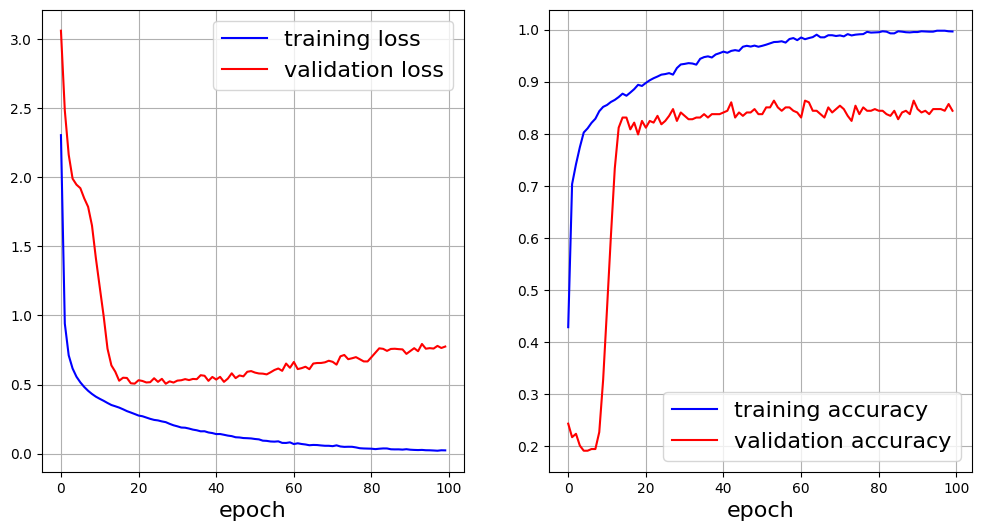

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-r', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

### Test the model

In [18]:
#load the best model
best_epoch=np.argmax(acc_val_list)
best_epoch

53

In [19]:
import tensorflow
model = tensorflow.keras.models.load_model("ECG_Keras_sCE_e"+str(best_epoch)+".h5")

In [20]:
score = model.evaluate(X_test, Y_test, batch_size=64, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.31859463453292847
Test accuracy: 0.899869978427887


### Make Prediction on the test set

In [21]:
Y_test_pred=model.predict(X_test, batch_size=64)

13/13 [==============================] - 0s 1ms/step


In [22]:
Y_test_pred[0]

array([2.43612430e-05, 9.99969006e-01, 5.96248867e-07, 7.48215996e-07,
       4.97713745e-06, 5.31262039e-08, 1.21415345e-12, 1.71759762e-09,
       1.05466169e-08, 1.43039483e-10, 3.07373238e-10, 9.49408677e-11,
       4.41243913e-08, 3.76920806e-09, 1.02652765e-11, 2.60889019e-11,
       9.19279652e-10, 3.51488810e-10, 1.03552606e-08, 2.66527653e-08,
       6.21298657e-09, 4.34142555e-10, 4.52253845e-10, 1.14015293e-07,
       4.88021179e-09, 4.40060099e-10, 5.12617102e-11, 3.33819514e-08,
       2.01388517e-10, 4.17285512e-10, 1.20492375e-11, 1.81959836e-10],
      dtype=float32)

In [23]:
np.argmax(Y_test_pred[0])

1

In [24]:
Y_test[0]

1

In [25]:
Y_test_pred=np.argmax(Y_test_pred, axis=1)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       176
           1       0.82      0.88      0.85       154
           2       0.96      0.91      0.93       146
           3       0.92      0.94      0.93       122
           4       0.97      0.96      0.96       171

    accuracy                           0.90       769
   macro avg       0.90      0.90      0.90       769
weighted avg       0.90      0.90      0.90       769

